# Running ML Models

## Setup

In [1]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# Specify the file path
file_path = "../CEIP_csv/ml_data_withstrats.csv"

# Load the CSV file into a pandas DataFrame called df
df = pd.read_csv(file_path)

util = 'calcUtil' # define the target

## Feature selection

In [3]:
# FEATURE SELECTION
# list the columns in the dataframe
column_list = df.columns.tolist()

# list of index columns (like ixNest, ixJobSummary, ixPart)
indices = [column for column in column_list if column.startswith('ix')]

# list of strategy type column names 
auto_strategies = [column for column in column_list if column.startswith('AutoStrat')]
f_strategies = [column for column in column_list if column.startswith('fStrat')] 
strategies = [auto_strategies, f_strategies]

nest_data = ['cTimesCut', 'fAllPartsNested', 'cParts', 'dNestingTime', 
             'dLengthUsed', 'dWidthUsed', 'dPartArea']
# cTimesCut - removed, # of times nest will be cut in job, not known in advance 
# fAllPartsNested - removed, just a 0/1 indicator of if all the parts in the job were nested using automatic nesting
# cParts - Total number of parts nested from Nest table - duplicated by cNested, unknown prior to nesting 
# analysis - check if cParts is identical to cNested, what are the differences 
# !! fStrategies might actually be helpful for tree based models - try adding later 
# fStrategies - what is the meaning of this? does it add anything? 
# dNestingTime - analyze later but not a feature 
# dLengthUsed & dWidthUsed - Length/width of plate used by nested parts - not features 
# dPartArea - Total area of nested parts - replicated by dPartTrueArea, from Nest Table 

# exclude the # of parts nested and the # required - not part characteristics 
others = ['cNested', 'cRequired']

# select all the columns that are actually features 
# exclude the auto_strategies for now - just use fstrategies 
non_features = set().union(indices, nest_data, others, auto_strategies)

# Get all columns from the DataFrame as a set
all_columns_set = set(df.columns)

# Subtract the sets of columns you don't want from the set of all columns
selected_columns_set = all_columns_set - non_features
feature_list = list(selected_columns_set) # Convert the resulting set back to a list

# feature list without strategies 
strategies_plus = set().union(indices, nest_data, others, f_strategies, auto_strategies)
columns_nostrats = all_columns_set - strategies_plus
features_nostrats = list(columns_nostrats)

## More data cleaning for ML models

In [23]:
data_original = df.copy() # copy the original dataframe (has all data including non-features)

# make a df with allfeatures (keep only the features in feature_list) 
data = df[feature_list]

# make a df with only part features, not including strats (keep only the features in features_nostrats list)
data_nostrats = df[features_nostrats]

In [24]:
# Fill missing values with the median of the column
# use median because our data is highly skewed & not normally distributed 
data = data.fillna(data.median())

In [25]:
# drop any na values, infinity or negative values 

# Replace infinity values with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# # Replace infinity values with a zero value 
# data = data.replace([np.inf, -np.inf], 0)

# Replace 0 with a small number to avoid division by zero error
data = data.replace(0, 1e-9)

# Drop rows with missing values
data = data.dropna()

### Remove outliers

In [27]:
# find numbers that should be removed & analyze them 
# Initialize the result dictionary
result = {}

# Find columns with negative values
negative_values = data.lt(0).sum()

# Find columns with very large values (greater than the 99th percentile)
large_values = data.gt(data.quantile(.99)).sum()

# Find outliers using the IQR method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 3 * IQR)) | (data > (Q3 + 3 * IQR))).sum()

# Find columns with infinity values
infinity_values = data.eq(np.inf).sum()

# Combine the results into the dictionary
for column in data.columns:
    result[column] = {
        'Negative Values': negative_values[column],
        'Large Values': large_values[column],
        'Outliers': outliers[column],
        'Infinity Values': infinity_values[column]
    }

# Print the results
for column, counts in result.items():
    print(f"{column}:")
    for key, value in counts.items():
        print(f"  {key}: {value}")
    print()
    
# these are saved to outlier_counts.txt file 

dLgIntArea:
  Negative Values: 0
  Large Values: 40187
  Outliers: 595510
  Infinity Values: 0

fStrat_IntelliNest:
  Negative Values: 0
  Large Values: 0
  Outliers: 313332
  Infinity Values: 0

fStrat_Strategy3:
  Negative Values: 0
  Large Values: 0
  Outliers: 76083
  Infinity Values: 0

dSheetLength:
  Negative Values: 0
  Large Values: 21109
  Outliers: 2883
  Infinity Values: 0

fStrat_Strategy4:
  Negative Values: 0
  Large Values: 0
  Outliers: 987912
  Infinity Values: 0

dLgExtConBoundaryDist:
  Negative Values: 0
  Large Values: 38613
  Outliers: 331313
  Infinity Values: 0

fStrat_ICProfileNesting:
  Negative Values: 0
  Large Values: 0
  Outliers: 697235
  Infinity Values: 0

fStrat_Strategy9:
  Negative Values: 0
  Large Values: 0
  Outliers: 60085
  Infinity Values: 0

dExtBoundaryDist:
  Negative Values: 0
  Large Values: 40726
  Outliers: 128372
  Infinity Values: 0

fStrat_Strategy6:
  Negative Values: 0
  Large Values: 37818
  Outliers: 37818
  Infinity Values: 0

d

In [30]:
def remove_multi_outliers_iqr(df, columns, multiplier=3, outlier_threshold=5):
    """
    This function removes the rows from a dataframe that have outliers in multiple columns based on the IQR method.
    The function takes as arguments:
        - df: the dataframe
        - columns: the columns on which to calculate and remove outliers
        - multiplier: the multiplier for the IQR to define the range (default is 3)
        - outlier_threshold: the number of columns with outliers a row must have to be removed (default is 3)
    It returns the dataframe with outliers removed.
    """
    outlier_count = pd.Series(index=df.index, data=0)
    
    for column in columns:
        # Calculate Q1, Q3, and IQR
        Q1, Q3 = df[column].quantile([0.25, 0.75])
        IQR = Q3 - Q1

        # Define a condition for the outliers
        condition = (df[column] < Q1 - multiplier * IQR) | (df[column] > Q3 + multiplier * IQR)

        # Add the outliers to the count
        outlier_count += condition

    # Filter out the rows with too many outliers
    df_filtered = df[outlier_count < outlier_threshold]

    # Print the number of rows removed
    print(f"Rows removed: {df.shape[0] - df_filtered.shape[0]}")

    return df_filtered

# Apply this function to all numeric columns in the DataFrame
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# applying this to a copy of the data to avoid modifying originals 
data_nooutliers = data.copy() 

# remove all of the rows with too many outliers from the dataframe (modify in-place)
data_nooutliers = remove_multi_outliers_iqr(data_nooutliers, numeric_cols)

# Print the new number of rows in the DataFrame
print(f"\nNew number of rows in the DataFrame: {data_nooutliers.shape[0]}")

# for threshold of 3 outliers per row => removed 
# Rows removed: 1100087

# New number of rows in the DataFrame: 2972428

Rows removed: 252956

New number of rows in the DataFrame: 3819559


### Training & Testing sets + Scaling

In [34]:
# Assuming you have a pandas DataFrame called 'data' with features and target columns
# set the data to the data with no outliers, save the other as a data with outliers
data_with_outliers = data.copy()
data = data_nooutliers

# util = target = calcUtil 
X = data.drop(util, axis=1)  # Features
y = data[util]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# # scaling 
#! COmmented out - this results in an error 
# # Standardize the features (mean=0, standard deviation=1). Fit on the training data and transform both the training and testing data.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1014: RuntimeWarning: overflow encountered in square
  temp **= 2
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:80: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


## Linear Regression 

In [36]:
# Initialize the linear regression model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

LinearRegression()

In [39]:
# Predict on the testing data
y_pred = lr_model.predict(X_test)

# Calculate evaluation metrics
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
    'R2': r2_score(y_test, y_pred),
    'Explained Variance': explained_variance_score(y_test, y_pred)
}

# Print the evaluation metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

MAE: 1.0535915790520227e+273
MSE: inf
RMSE: inf
R2: nan
Explained Variance: nan


/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:805: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:807: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2
/Users/jerhadf/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:813: RuntimeWarning: invalid 

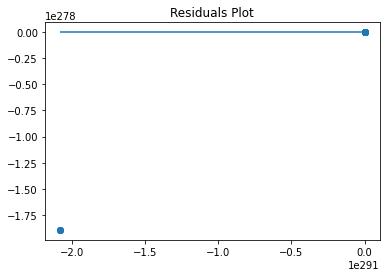

In [40]:
# Plotting residuals
plt.scatter(y_pred, y_pred - y_test)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max())
plt.title('Residuals Plot')
plt.show()

In [ ]:
# Plotting predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:

# Convert continuous predictions to binary to calculate classification metrics
target_pred_binary = np.where(target_pred > 0.5, 1, 0)

# Calculate additional metrics
metrics.update({
    'Accuracy': accuracy_score(target_test, target_pred_binary),
    'ROC AUC': roc_auc_score(target_test, target_pred_binary),
    'Confusion Matrix': confusion_matrix(target_test, target_pred_binary)
})

# Print the evaluation metrics
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")

In [ ]:
# Plotting ROC Curve
plot_roc_curve(lr_model, features_test, target_test)
plt.title('ROC AUC Curve')
plt.show()

In [ ]:
# Plotting Confusion Matrix
plot_confusion_matrix(lr_model, features_test, target_test)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plotting residuals
plt.scatter(target_pred, target_pred - target_test)
plt.hlines(y=0, xmin=target_pred.min(), xmax=target_pred.max())
plt.title('Residuals Plot')
plt.show()

In [ ]:
# Plotting predicted vs actual values
plt.scatter(target_test, target_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
# Get the feature importances
importance = model.coef_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

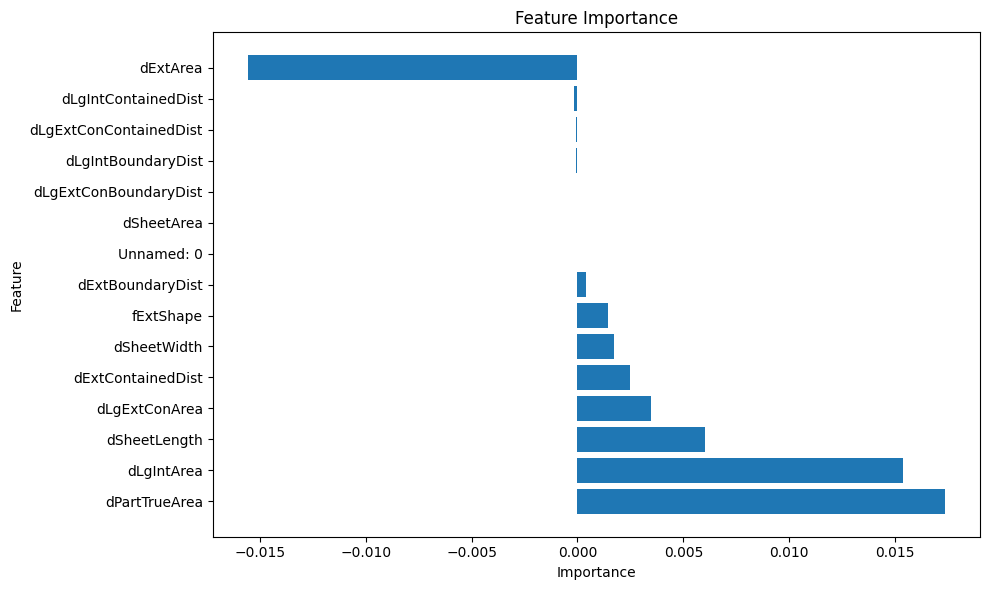

Mean Absolute Error (MAE): 28.629401886356185
Mean Squared Error (MSE): 26051199.67334449
Root Mean Squared Error (RMSE): 5104.037585416519
R-squared (R2) Score: 1.0003102358657756e-06
Explained Variance Score: 1.4777116668085455e-06


In [ ]:
# Assuming you have a pandas DataFrame called 'data' with features and target columns
X = data.drop('calcUtil', axis=1)  # Features
y = data['calcUtil']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Bayesian Ridge regression model
model = BayesianRidge()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Get the feature importances
importance = model.coef_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Explained Variance Score:", explained_var)

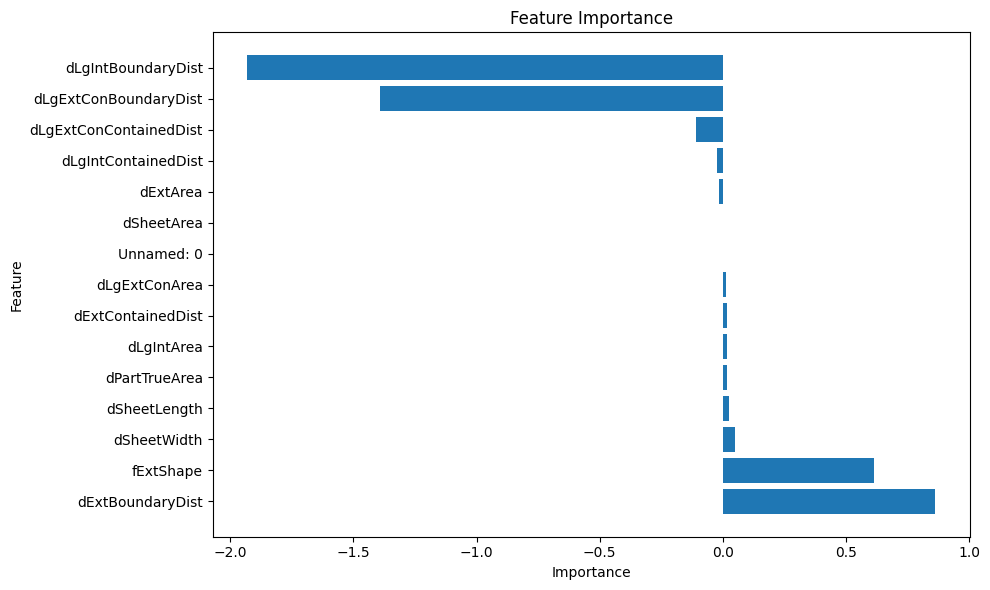

Mean Absolute Error (MAE): 29.085869876063967
Mean Squared Error (MSE): 26050703.467950974
Root Mean Squared Error (RMSE): 5103.988976080471
R-squared (R2) Score: 2.004760569174202e-05
Explained Variance Score: 2.0519600964719054e-05


In [ ]:
#Least Angle Regression (LARS) model

# Specify the file path
file_path = "ml_data (1).csv"

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Assuming you have a pandas DataFrame called 'data' with features and target columns
X = data.drop('calcUtil', axis=1)  # Features
y = data['calcUtil']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Least Angle Regression (LARS) model
model = Lars()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Get the feature importances
importance = model.coef_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Explained Variance Score:", explained_var)


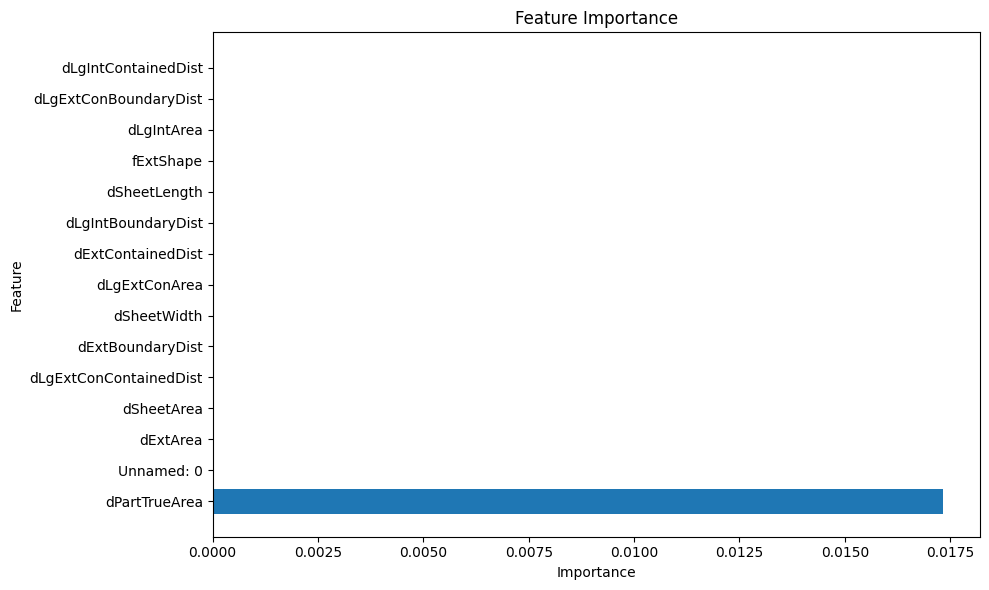

Mean Absolute Error (MAE): 34.27378412809895
Mean Squared Error (MSE): 26052988.935348976
Root Mean Squared Error (RMSE): 5104.212861485008
R-squared (R2) Score: -6.768213959773561e-05
Explained Variance Score: -6.718201418465242e-05


In [ ]:

# Load the CSV file into a pandas DataFrame
data = pd.read_csv("ml_data (1).csv")

# Assuming you have a pandas DataFrame called 'data' with features and target columns
X = data.drop('calcUtil', axis=1)  # Features
y = data['calcUtil']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Orthogonal Matching Pursuit (OMP) model
model = OrthogonalMatchingPursuit()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

# Get the feature importances
importance = model.coef_

# Create a DataFrame with feature names and importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Print the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("Explained Variance Score:", explained_var)


In [ ]:
# Create a dictionary with the model names and evaluation metrics
results = {
    'Model': ['Linear Regression', 'Bayesian Ridge', 'Least Angle Regression', 'Orthogonal Matching Pursuit'],
    'MAE': [29.085869876063647, 28.629401886356185, 29.085869876063967, 34.27378412809895],
    'MSE': [26050703.467950974, 26051199.67334449, 26050703.467950974, 26052988.935348976],
    'RMSE': [5103.988976080471, 5104.037585416519, 5103.988976080471,  5104.212861485008],
    'R2': [2.004760569174202e-05, 1.0003102358657756e-06, 2.004760569174202e-05, -6.768213959773561e-05],
    'Explained Variance': [2.0519600964719054e-05, 1.4777116668085455e-06, 2.0519600964719054e-05, -6.718201418465242e-05]
}

# Create a DataFrame from the results dictionary
df = pd.DataFrame(results)
import pandas as pd

# Create a dictionary with the model names and evaluation metrics
results = {
    'Model': ['Linear Regression', 'Bayesian Ridge', 'Least Angle Regression', 'Orthogonal Matching Pursuit'],
    'MAE': [29.085869876063647, 28.629401886356185, 29.085869876063967, 34.27378412809895],
    'MSE': [26050703.467950974, 26051199.67334449, 26050703.467950974, 26052988.935348976],
    'RMSE': [5103.988976080471, 5104.037585416519, 5103.988976080471,  5104.212861485008],
    'R2': [2.004760569174202e-05, 1.0003102358657756e-06, 2.004760569174202e-05, -6.768213959773561e-05],
    'Explained Variance': [2.0519600964719054e-05, 1.4777116668085455e-06, 2.0519600964719054e-05, -6.718201418465242e-05]
}

# Create a DataFrame from the results dictionary
df = pd.DataFrame(results)

# Apply formatting to the DataFrame
styled_df = df.style.format({
    'MAE': '{:.3f}',
    'MSE': '{:.3f}',
    'RMSE': '{:.3f}',
    'R2': '{:.3e}',
    'Explained Variance': '{:.3e}'
}).hide_index()

# Set the style properties for the table
styled_df.set_properties(**{
    'text-align': 'center',
    'border-color': 'lightgray',
    'border-style': 'solid',
    'border-width': '1px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('background-color', 'lightgray')]
}])

# Display the styled DataFrame
display(styled_df)

# Print the DataFrame
print(df)


/var/folders/17/p71czdwj66n1sxc4d0f6c45m0000gn/T/ipykernel_56454/2177836466.py:37: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  }).hide_index()


Model,MAE,MSE,RMSE,R2,Explained Variance
Linear Regression,29.086,26050703.468,5103.989,2.005e-05,2.052e-05
Bayesian Ridge,28.629,26051199.673,5104.038,1.000e-06,1.478e-06
Least Angle Regression,29.086,26050703.468,5103.989,2.005e-05,2.052e-05
Orthogonal Matching Pursuit,34.274,26052988.935,5104.213,-6.768e-05,-6.718e-05


                         Model        MAE           MSE         RMSE  \
0            Linear Regression  29.085870  2.605070e+07  5103.988976   
1               Bayesian Ridge  28.629402  2.605120e+07  5104.037585   
2       Least Angle Regression  29.085870  2.605070e+07  5103.988976   
3  Orthogonal Matching Pursuit  34.273784  2.605299e+07  5104.212861   

         R2  Explained Variance  
0  0.000020            0.000021  
1  0.000001            0.000001  
2  0.000020            0.000021  
3 -0.000068           -0.000067  
